# Gigs Senior Data Analyst Challenge

Welcome to the Gigs data analyst take-home challenge! This notebook will help you get started with analyzing our connectivity usage data.

## About the Data

You'll be working with three main datasets:
- **Usage Data**: Detailed usage per subscription period (~100K+ records)
- **Plan Events**: Plan configuration and pricing history
- **Projects**: Project metadata

## Setup Instructions

Run the cells below to set up your environment and load the data into DuckDB.

In [1]:
# Import required libraries
import duckdb
import pandas as pd
from datetime import datetime, timedelta

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Load JupySQL extension and configure
%load_ext sql

# Configure JupySQL for better output
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

print("✅ JupySQL configured!")

✅ JupySQL configured!


In [3]:
# Connect to DuckDB
conn = duckdb.connect('gigs-analytics.db')
%sql conn --alias duckdb

print("✅ Connected to DuckDB database: gigs-analytics.db")

✅ Connected to DuckDB database: gigs-analytics.db


In [4]:
%%sql
-- Load data into DuckDB tables
CREATE
OR REPLACE TABLE usage_data AS
SELECT
  *
FROM
  'data/usage_by_subscription_period.csv';

CREATE
OR REPLACE TABLE plan_events AS
SELECT
  *
FROM
  'data/plan_change_events.csv';

CREATE
OR REPLACE TABLE projects AS
SELECT
  *
FROM
  'data/projects.csv';

,Count
0,3


In [5]:
%%sql
-- Verify data loading
SELECT
  'usage_data' AS table_name,
  COUNT(*) AS row_count,
  COUNT(DISTINCT subscription_id) AS unique_subscriptions
FROM
  usage_data
UNION ALL
SELECT
  'plan_events' AS table_name,
  COUNT(*) AS row_count,
  COUNT(DISTINCT plan_id) AS unique_plans
FROM
  plan_events
UNION ALL
SELECT
  'projects' AS table_name,
  COUNT(*) AS row_count,
  COUNT(DISTINCT project_id__hashed) AS unique_projects
FROM
  projects;

,table_name,row_count,unique_subscriptions
0,usage_data,53565,8457
1,plan_events,209,36
2,projects,3,3


## Your Analysis Starts Here!

Now you have everything set up. Use the cells below to start your analysis.

### Tips:
- Use `%%sql` for multi-line SQL queries
- Use `%%sql variable_name <<` to store results in a Python variable
- Combine SQL with Python/Pandas for advanced analysis
- Feel free to use any visualisation library you feel comfortable with

# 0. Data Exploration

In [6]:
%%sql 
--sanity checks for the datasets
SELECT *
FROM projects;
/* 3 projects; 2 project types; 2 device types
*/

,project_id__hashed,project_type,organization_name,device_type


In [7]:
conn.sql("SUMMARIZE plan_events").df().head()

# All prices are in USD - no conversion required
# No voice or SMS allowance values, but some unlimited plans 

# Open questions:
# Check if all is_unlimited_data = false have some data_allowance - nope, all good
# What is validity value? Looks like period
# Should I only use the current data? How to utilize the historicals? 
# connect plan_name with the plan values

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,plan_id,VARCHAR,pln_0a3b55b9abb575b023c07e617b49,pln_e4a7120c0bc0b1a583d931cf5815,38,None,None,None,None,None,209,0.0
1,project_id__hashed,VARCHAR,2aeca1a6c1ecf52b28b7f7646b6fb90563a417ee3e5dc3...,dace2786aee7632e61757b320a6fe5bff37a2e742fe558...,3,None,None,None,None,None,209,0.0
2,plan_created_at,TIMESTAMP,2023-12-29 18:42:14,2025-05-23 18:56:56,38,2024-12-28 04:50:49.545455,None,2025-02-26 13:21:21.25,2025-03-06 13:54:15,2025-03-27 09:37:34.25,209,0.0
3,event_type,VARCHAR,plan.archived,plan.updated,4,None,None,None,None,None,209,0.0
4,event_timestamp,TIMESTAMP,2023-12-29 18:42:14.796361,2025-10-04 10:09:40.396422,242,2025-01-22 03:15:00.721157,None,2025-03-06 13:24:39.094076,2025-03-24 13:21:52.995934,2025-04-03 13:24:18.187881,209,0.0


In [8]:
%%sql 
--sanity check - does "is_unlimited_data" flag correspond with the "plan_name"? 
SELECT
      _is_current_state,
      plan_name,
      network_provider_id,
      data_allowance_mb,
      is_unlimited_data,
      voice_allowance_seconds,
      is_unlimited_voice,
      sms_allowance,
      is_unlimited_sms,
      COUNT(*)
FROM plan_events
GROUP BY 1,2,3,4,5,6,7,8,9
ORDER BY 1 DESC,2,5 DESC,7 DESC,9 DESC
LIMIT 5
  /*
  Based on that, I'd aggregate the various plans names into bundles for usage analysis:
  CASE WHEN is_unlimited_data
  THEN 'Unlimited'
  WHEN  data_allowance_mb = 5000
  THEN  '5GB'
  WHEN data_allowance_mb = 1000
  THEN '1GB'
  WHEN data_allowance_mb = 0
  THEN 'No Allowance'
  END AS plan_type*/

,_is_current_state,plan_name,network_provider_id,data_allowance_mb,is_unlimited_data,voice_allowance_seconds,is_unlimited_voice,sms_allowance,is_unlimited_sms,count_star()
0,True,5GB,p11,5000.0,False,NaN,True,NaN,True,3
1,True,5GB Plan,p11,5000.0,False,NaN,True,NaN,True,5
2,True,5GB Test Plan,p9,5000.0,False,NaN,True,NaN,True,1
3,True,Basic Plan,p13,5000.0,False,NaN,True,NaN,True,1
4,True,Easy Plan,p9,1000.0,False,NaN,True,NaN,True,1


In [9]:
%%sql
-- Confirming that one project can have multiple plans
SELECT
      _is_current_state,
      project_id__hashed,
      COUNT(plan_id),
      COUNT(DISTINCT plan_id)
FROM plan_events
GROUP BY 1, 2
ORDER BY 1 DESC, 2

,_is_current_state,project_id__hashed,count(plan_id),count(DISTINCT plan_id)
0,True,2aeca1a6c1ecf52b28b7f7646b6fb90563a417ee3e5dc3...,4,4
1,True,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,6,6
2,True,dace2786aee7632e61757b320a6fe5bff37a2e742fe558...,26,26
3,False,2aeca1a6c1ecf52b28b7f7646b6fb90563a417ee3e5dc3...,13,4
4,False,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,34,6
5,False,dace2786aee7632e61757b320a6fe5bff37a2e742fe558...,126,26


In [10]:
%%sql
/* Quick check to confirm that each plan_id has only one data_allowance_mb historically */
SELECT
      plan_id,
      COUNT(DISTINCT COALESCE(data_allowance_mb, 999999999))
FROM plan_events
GROUP BY 1
HAVING COUNT(DISTINCT COALESCE(data_allowance_mb, 999999999)) > 1

,plan_id,"count(DISTINCT COALESCE(data_allowance_mb, 999999999))"


In [11]:
%%sql 
--checking a snippet to see what the data looks like
SELECT *
FROM plan_events
WHERE plan_id = 'pln_c5b25fc1ad1cfcaf90a87b7e086a'
ORDER BY event_timestamp
LIMIT 5

,plan_id,project_id__hashed,plan_created_at,event_type,event_timestamp,plan_name,network_provider_id,price_currency,plan_price_amount_local,data_allowance_mb,is_unlimited_data,voice_allowance_seconds,is_unlimited_voice,sms_allowance,is_unlimited_sms,validity_value,validity_unit,_valid_from,_valid_to,_is_current_state
0,pln_c5b25fc1ad1cfcaf90a87b7e086a,2aeca1a6c1ecf52b28b7f7646b6fb90563a417ee3e5dc3...,2025-02-25 19:26:53,plan.created,2025-02-25 19:26:53.529127,Unlimited Plan,p13,USD,40.0,NaN,True,NaN,True,NaN,True,30,day,2025-02-25 19:26:53.000000,2025-02-25 19:26:54.153130,False
1,pln_c5b25fc1ad1cfcaf90a87b7e086a,2aeca1a6c1ecf52b28b7f7646b6fb90563a417ee3e5dc3...,2025-02-25 19:26:53,plan.updated,2025-02-25 19:26:54.153130,Unlimited Plan,p13,USD,40.0,NaN,True,NaN,True,NaN,True,30,day,2025-02-25 19:26:54.153130,2025-02-25 19:28:35.624102,False
2,pln_c5b25fc1ad1cfcaf90a87b7e086a,2aeca1a6c1ecf52b28b7f7646b6fb90563a417ee3e5dc3...,2025-02-25 19:26:53,plan.updated,2025-02-25 19:28:35.624102,Unlimited Plan,p13,USD,40.0,NaN,True,NaN,True,NaN,True,30,day,2025-02-25 19:28:35.624102,2025-02-25 19:28:35.658340,False
3,pln_c5b25fc1ad1cfcaf90a87b7e086a,2aeca1a6c1ecf52b28b7f7646b6fb90563a417ee3e5dc3...,2025-02-25 19:26:53,plan.published,2025-02-25 19:28:35.658340,Unlimited Plan,p13,USD,40.0,NaN,True,NaN,True,NaN,True,30,day,2025-02-25 19:28:35.658340,2025-02-26 10:14:33.426678,False
4,pln_c5b25fc1ad1cfcaf90a87b7e086a,2aeca1a6c1ecf52b28b7f7646b6fb90563a417ee3e5dc3...,2025-02-25 19:26:53,plan.updated,2025-02-26 10:14:33.426678,Unlimited Plan,p13,USD,40.0,NaN,True,NaN,True,NaN,True,30,day,2025-02-26 10:14:33.426678,2025-04-25 09:00:39.823465,False


In [12]:
%%sql
SELECT
  ud.project_id__hashed,
  p.project_type,
  p.organization_name,
  p.device_type,
  ud.plan_id,
  pe.plan_name,
  COUNT(DISTINCT subscription_id)
FROM usage_data ud
LEFT JOIN projects p USING (project_id__hashed)
LEFT JOIN (SELECT DISTINCT plan_id, plan_name 
           FROM plan_events) pe USING (plan_id)
GROUP BY
  1,2,3,4,5,6
ORDER BY 7 DESC
LIMIT 5

,project_id__hashed,project_type,organization_name,device_type,plan_id,plan_name,count(DISTINCT subscription_id)
0,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,Connect,ACME Phone,Phones,pln_0a3b55b9abb575b023c07e617b49,Easy Plan,5963
1,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,Connect,ACME Phone,Phones,pln_1d3f49d61a672755efc1865c4d9a,Unlimited Data Plan,617
2,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,Connect,ACME Phone,Phones,pln_af7b4a30086929d37e7f4eb3daed,Plus Plan,534
3,2aeca1a6c1ecf52b28b7f7646b6fb90563a417ee3e5dc3...,Connect,SmartDevices Inc.,Wearables,pln_a77a368011e31330c4ce88614272,Unlimited Plan,526
4,dace2786aee7632e61757b320a6fe5bff37a2e742fe558...,API,People Mobile,Phones,pln_b109c69e95246b6d535b9cc9174f,Ultra Unlimited,506


In [13]:
%%sql
/* In most cases (~80%) the reporting date doesn't match subscription_period_end. 
Assumption: mostly subscription_period_end is not included in the plan - e.g. if it's 2025-01-01, it means that plan can be used until 2024-12-31 23:59:59*/
WITH
last_reporting_date_usage AS (
    SELECT *
    FROM usage_data
    WINDOW w1 AS (PARTITION BY subscription_id, subscription_period_start, project_id__hashed, plan_id) 
    QUALIFY reporting_date = MAX(reporting_date) OVER w1
)
SELECT reporting_date = subscription_period_end AS date_match,
       COUNT(DISTINCT subscription_id) AS sub_cnt
FROM last_reporting_date_usage
GROUP BY 1

,date_match,sub_cnt
0,True,2154
1,False,8013


In [14]:
%%sql
/* [1] Cases when subscription_period_start has multiple subscription_period_end (with the same subscription_period_number) */
SELECT *
FROM usage_data
WINDOW w1 AS (PARTITION BY subscription_id, subscription_period_start, project_id__hashed, plan_id) 
QUALIFY COUNT(*) OVER w1 > 1
ORDER BY subscription_id, subscription_period_start, subscription_period_end
LIMIT 5

,subscription_id,project_id__hashed,plan_id,reporting_date,subscription_period_start,subscription_period_end,subscription_period_number,cumulative_data_usage_megabyte,cumulative_voice_usage_minutes,cumulative_sms_usage,number_of_addons_activated
0,sub_09fc9a36f53ced9cbed4052ba087,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-05-25,2024-04-26,2024-05-26,1,272.401408,301.0,492.0,0
1,sub_09fc9a36f53ced9cbed4052ba087,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-08-01,2024-04-26,2024-08-01,1,272.401408,301.0,492.0,0
2,sub_0a6c11a5aba96a01ff34f20a9f5d,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-06-28,2024-05-29,2024-06-29,4,15.772672,29.0,4.0,0
3,sub_0a6c11a5aba96a01ff34f20a9f5d,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-07-30,2024-05-29,2024-07-30,4,15.772672,29.0,4.0,0
4,sub_0dd117a00ba2831e4b5cdf7632c8,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_1d3f49d61a672755efc1865c4d9a,2024-05-28,2024-04-29,2024-05-29,3,1739.095040,314.0,64.0,0


In [15]:
%%sql
/* Digging into the duplicate cases from above - checking if cumulative_data_usage_megabyte is always the same */
WITH
  mismatched_data_usage AS (
    SELECT
      subscription_id || subscription_period_start || project_id__hashed || plan_id AS concat_id
    FROM
      usage_data
    WINDOW
      w1 AS (
        PARTITION BY
          subscription_id,
          subscription_period_start,
          project_id__hashed,
          plan_id
        ORDER BY
          reporting_date DESC
      ) QUALIFY COUNT(*) OVER w1 > 1
      /*Filtering for cases when cumulative_data_usage_megabyte is different from the previous subscription_period_end*/
      AND cumulative_data_usage_megabyte <> LAG (cumulative_data_usage_megabyte, 1) OVER w1
  )
SELECT
  subscription_id,
  project_id__hashed,
  plan_id,
  subscription_period_start,
  MIN(reporting_date) OVER w1 AS reporting_date,
  FIRST_VALUE (cumulative_data_usage_megabyte) OVER w2 AS data_usage
FROM
  usage_data
WHERE
  subscription_id || subscription_period_start || project_id__hashed || plan_id IN (
    SELECT
      concat_id
    FROM
      mismatched_data_usage
  )
WINDOW
  w1 AS (
    PARTITION BY
      subscription_id,
      subscription_period_start,
      project_id__hashed,
      plan_id
  ),
  w2 AS (
    PARTITION BY
      subscription_id,
      subscription_period_start,
      project_id__hashed,
      plan_id
    ORDER BY
      reporting_date DESC
  )
ORDER BY 1,2,3,4,5
  /* Found 6 subscriptions with mismatching usage data. Almost all of them are coming from the same plan_id. + reporting_date doesn't match the subscription_period_end
  Possible reasons for these duplicates:
  1. An addon to extend the subscription. However, subscription_period_number is not incremented, so I have to assume it's the ussage from the same period.
  2. Data fix - e.g. the originally recorded usage was wrong/not full, and was later fixed in db. Seems more likely - I will use this assumption in my calculations. 
  
  Hence, I will be using the last available cumulative_data_usage_megabyte, but calculate it against the first subscription_period_end to compare apples with apples. */

,subscription_id,project_id__hashed,plan_id,subscription_period_start,reporting_date,data_usage
0,sub_2f0ff572c468cc45ecdac90d3962,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-04-26,2024-05-25,83.863552
1,sub_2f0ff572c468cc45ecdac90d3962,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-04-26,2024-05-25,83.863552
2,sub_32369cb853a992d6053e06866f6c,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-11-25,2024-12-24,1520.844800
3,sub_32369cb853a992d6053e06866f6c,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-11-25,2024-12-24,1520.844800
4,sub_34d771b26da00b48f479e7a6c826,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-11-30,2024-12-29,16.509952
5,sub_34d771b26da00b48f479e7a6c826,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-11-30,2024-12-29,16.509952
6,sub_3d8b02b4286318cc0facc72ce006,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_af7b4a30086929d37e7f4eb3daed,2025-02-28,2025-03-29,3699.315712
7,sub_3d8b02b4286318cc0facc72ce006,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_af7b4a30086929d37e7f4eb3daed,2025-02-28,2025-03-29,3699.315712
8,sub_c6f9840b6e587c0104081f83ad6b,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-03-18,2024-04-17,6350.060544
9,sub_c6f9840b6e587c0104081f83ad6b,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-03-18,2024-04-17,6350.060544


In [16]:
%%sql
/* Removing the usage duplicates generated by [1] */
SELECT DISTINCT
  subscription_id,
  project_id__hashed,
  plan_id,
  subscription_period_start,
  /*Assuming that the latter reporting_date is a data fix, I'll be using the "original" reporting date for correct comparison */
  MIN(reporting_date) OVER w1 AS reporting_date,
  subscription_period_number,
  /*Using the last available usage information*/
  FIRST_VALUE (cumulative_data_usage_megabyte) OVER w2 AS data_usage
FROM usage_data
WINDOW w1 AS (PARTITION BY subscription_id, subscription_period_start, project_id__hashed, plan_id),
       w2 AS (PARTITION BY subscription_id, subscription_period_start, project_id__hashed, plan_id ORDER BY reporting_date DESC)
QUALIFY COUNT(*) OVER w1 > 1
LIMIT 5

,subscription_id,project_id__hashed,plan_id,subscription_period_start,reporting_date,subscription_period_number,data_usage
0,sub_09fc9a36f53ced9cbed4052ba087,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-04-26,2024-05-25,1,272.401408
1,sub_ed26be63b9889ef506d72cdf383c,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-04-03,2024-05-02,2,1147.617280
2,sub_8a908de481b97b473770e61c82d2,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-12-14,2025-01-13,8,159.793152
3,sub_127b06ce0fb3ab1cfa194937c6f4,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-05-25,2024-06-24,2,64.889856
4,sub_c6f9840b6e587c0104081f83ad6b,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-03-18,2024-04-17,2,6350.060544


In [17]:
%%sql
/*Creating a new denormalized dataset with deduplicated events and additionbal fields required for the analysis*/ 
CREATE OR REPLACE TABLE deduplicated_usage AS
WITH

plans AS (
    SELECT DISTINCT
           plan_id,
           plan_name,
           CASE
             WHEN is_unlimited_data THEN 'Unlimited'
             WHEN data_allowance_mb = 5000 THEN '5GB'
             WHEN data_allowance_mb = 1000 THEN '1GB'
             WHEN data_allowance_mb = 0 THEN 'No Allowance'
           END AS plan_type,
           validity_unit
    FROM plan_events
),

raw_usage_data AS (
    SELECT
           subscription_id,
           project_id__hashed,
           plan_id,
           subscription_period_start,
           reporting_date,
           cumulative_data_usage_megabyte,
           subscription_period_number,
           COUNT(*) OVER w1 AS n_of_entries
    FROM usage_data
    WINDOW w1 AS (PARTITION BY subscription_id, subscription_period_start, project_id__hashed, plan_id)
),

deduplicated_multiple_entries AS (
    SELECT DISTINCT
      subscription_id,
      project_id__hashed,
      plan_id,
      subscription_period_start,
      /*Assuming that the latter reporting_date is a data fix, I'll be using the "original" reporting date for correct comparison */
      MIN(reporting_date) OVER w1 AS reporting_date,
      subscription_period_number,
      /*Using the last available usage information*/
      FIRST_VALUE (cumulative_data_usage_megabyte) OVER w2 AS data_usage
    FROM raw_usage_data
    WHERE n_of_entries > 1
    WINDOW w1 AS (PARTITION BY subscription_id, subscription_period_start, project_id__hashed, plan_id),
           w2 AS (PARTITION BY subscription_id, subscription_period_start, project_id__hashed, plan_id ORDER BY reporting_date DESC)
),

combined_deduplicated_usage AS (
    SELECT * EXCLUDE (n_of_entries)
    FROM raw_usage_data
    WHERE n_of_entries = 1
    
    UNION
    
    SELECT *
    FROM deduplicated_multiple_entries
)
SELECT
      u.*,
      p.plan_type,
      p.plan_name,
      p.validity_unit,
      reporting_date - subscription_period_start + INTERVAL 1 DAY AS full_days_in_period,
      pr.project_type,
      pr.organization_name,
      pr.device_type
FROM combined_deduplicated_usage u
LEFT JOIN plans p USING (plan_id)
LEFT JOIN projects pr USING (project_id__hashed)

,Count
0,53531


In [18]:
%%sql
/* There are a lot of cases when actual number of days in period (full_days_in_period) doesn't match the validity unit. Assumptions:
1. If  full_days_in_period < validity_unit (e.g. if it validity is month, but there are only 15 days), it means they churned preliminary. 
I will keep them in analysis and use the data to calculate daily usage
2. If full_days_in_period > validity_unit, I assume it's an error. We could either "normalise" these values (e.g. set them all to 31 days) or exclude from the analysis as anomalies. */
PIVOT deduplicated_usage ON validity_unit USING COUNT(*)
GROUP BY full_days_in_period
ORDER BY full_days_in_period DESC
LIMIT 5
  /*Also checked some cases when full_days_in_period > 1 and validity_unit = 'day' - some of them seem to be in fact monthly billed (e.g. example below). 
  Could be a mistake in validity_unit. Could be connected to plan change that occured*/
  -- SELECT *
  -- FROM deduplicated_usage
  -- WHERE TRUE 
  --       AND subscription_id = 'sub_51df580876c27b6add4d844b54f5'
  /*Based on that, I will stick to calculating actual full_days_in_period: reporting_date - subscription_start_date + INTERVAL 1 DAY to determine daily usage*/

,full_days_in_period,day,month
0,54 days,0,2
1,53 days,0,1
2,33 days,0,39
3,32 days,0,163
4,31 days,0,26824


In [19]:
%%sql 
/*Creating a dataset with aggregated data per each subscription and plan combination*/ CREATE
OR REPLACE TABLE usage_data_agg AS
SELECT *, 
       EXTRACT(DAY FROM last_reporting_date - first_subscription_period_start + INTERVAL 1 DAY) AS total_days,
       total_usage_in_period / EXTRACT(DAYS FROM last_reporting_date - first_subscription_period_start + INTERVAL 1 DAY) AS daily_usage,
       total_usage_in_period / n_of_periods AS usage_per_period
FROM (
        SELECT
          subscription_id,
          organization_name,
          project_type,
          device_type,
          plan_type,
          plan_name,
          MIN(subscription_period_start) AS first_subscription_period_start,
          MAX(reporting_date) AS last_reporting_date,
          SUM(cumulative_data_usage_megabyte) AS total_usage_in_period,
          COUNT(DISTINCT subscription_period_start) AS n_of_periods
        FROM deduplicated_usage
        GROUP BY 1,2,3,4,5,6
)

,Count
0,8912


In [21]:
%%sql
/* Daily usage */
SELECT *
FROM usage_data_agg
WHERE TRUE 
      AND total_usage_in_period > 0
LIMIT 5
/*Keep only active users - w/ usage > 0*/

,subscription_id,organization_name,project_type,device_type,plan_type,plan_name,first_subscription_period_start,last_reporting_date,total_usage_in_period,n_of_periods,total_days,daily_usage,usage_per_period
0,sub_041f959a9b5919c8e039cd81736c,ACME Phone,Connect,Phones,1GB,Easy Plan,2024-08-24,2025-05-23,411.693056,9,273,1.508033,45.743673
1,sub_1277ee4557c30c171927ddf7f2c1,ACME Phone,Connect,Phones,5GB,Plus Plan,2024-10-18,2025-05-17,15848.135680,7,212,74.755357,2264.019383
2,sub_1ac13c556e098836658781721022,ACME Phone,Connect,Phones,1GB,Easy Plan,2024-11-04,2025-06-03,369.963008,7,212,1.745109,52.851858
3,sub_1fc956c681306eea0a786ded87a8,ACME Phone,Connect,Phones,5GB,Plus Plan,2024-05-27,2025-05-26,0.029696,12,365,0.000081,0.002475
4,sub_239a7782776fce9b9f77e67c4f40,ACME Phone,Connect,Phones,1GB,Easy Plan,2024-03-04,2025-06-03,5850.271744,15,457,12.801470,390.018116


In [22]:
query = """
SELECT *
FROM usage_data_agg
WHERE TRUE
      AND total_usage_in_period > 0
"""
df_subscription_usage = conn.sql(query).df()

# Summary:
**Discoveries and assumptions:**
* **The data quality of plan_events** (e.g. Unlimited flags vs. plan names) appears consistent, so plan attributes can be treated as reliable for analysis. I noticed that some plans seems as if churned, but there is a new identical plan created almost simultaneously - will check that in more details later on.
* The analysis will focus on **subscriptions with strictly positive usage** (total_usage_in_period > 0), meaning zero-usage subscriptions are left out when looking at consumption behaviour.
* When comparing last_reporting_date to subscription_period_end, the data shows frequent mismatches. In practice, last_reporting_date is used as the effective end of activity, while subscription_period_end is treated more as an exclusive technical/end-of-validity field.
* Comparing full_days_in_period with validity_unit, the data often shows fewer days than the nominal validity, which is interpreted as early churn or early termination within the period; these cases are **kept and included in daily-usage calculations**.
* There are also cases where full_days_in_period is greater than the stated validity, which are treated as potential data or configuration issues and flagged as something to be handled carefully in later analysis.
* Based on these checks, **daily usage is calculated using actual elapsed days** (full_days_in_period), rather than relying on validity_unit.

# 1. How much data does a subscription typically consume? 

In [23]:
summary = df_subscription_usage["daily_usage"].agg(
    ["count", "mean", "median", "std", "min", "max"]
).round(2)

print(summary)

count      7996.00
mean        126.63
median        9.41
std         497.52
min           0.00
max       11748.00
Name: daily_usage, dtype: float64


In [24]:
s = df_subscription_usage["daily_usage"]

mean = s.mean()
std = s.std()
cv = std / mean
print(cv)

3.92903255294508


In [25]:
median = s.median()
ratio = mean / median
diff = (mean - median) / mean
print(ratio, diff)

13.462312911746487 0.9257185591691711


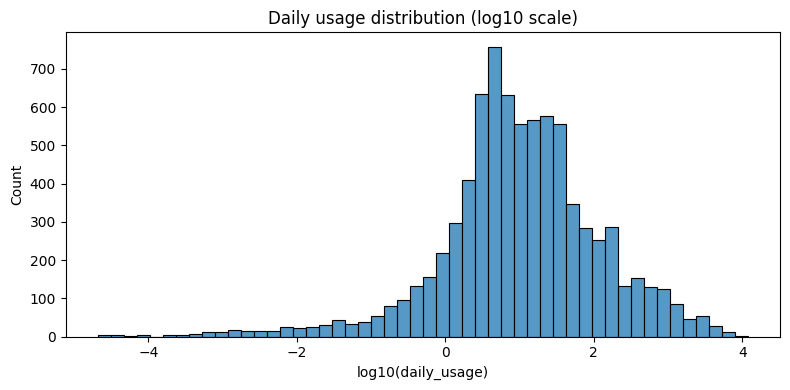

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

s_pos = s[s > 0]
plt.figure(figsize=(8, 4))
sns.histplot(np.log10(s_pos), bins=50)

plt.title("Daily usage distribution (log10 scale)")
plt.xlabel("log10(daily_usage)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Comments:
Daily usage shows very high variability and strong right skew.
<br>The coefficient of variation is ~3.9, meaning the **standard deviation is almost four times the mean**. 
<br>The Mean daily usage (126.6) is roughly 13 times the Median (9.4), indicating that a small number of **very heavy users pull the average upwards**.
<br><br>**Next step**: analyse without outlyers.

In [30]:
# 5th and 95th percentiles of daily_usage (to remove 5% from top and bottom)
q_low  = df_subscription_usage["daily_usage"].quantile(0.05)
q_high = df_subscription_usage["daily_usage"].quantile(0.95)

df_trimmed = df_subscription_usage[(df_subscription_usage["daily_usage"] >= q_low) & (df_subscription_usage["daily_usage"] <= q_high)]

print("Original rows:", len(df_subscription_usage))
print("Trimmed rows:", len(df_trimmed))
print("5th percentile:", q_low)
print("95th percentile:", q_high)


Original rows: 7996
Trimmed rows: 7196
5th percentile: 0.1650944
95th percentile: 604.825811827451


In [31]:
summary_trimmed = df_trimmed["daily_usage"].agg(
    ["count", "mean", "median", "std", "min", "max"]
).round(2)

print(summary_trimmed)

count     7196.00
mean        43.28
median       9.41
std         88.72
min          0.17
max        604.69
Name: daily_usage, dtype: float64


## Top Heavy users

In [33]:
#Majority of the heavy users are from People Mobile
df_heavy_users = df_subscription_usage[df_subscription_usage["daily_usage"] >= q_high]

heavy_by_org = (
    df_heavy_users
        .groupby("organization_name")
        .agg(n_heavy_subscriptions=("subscription_id", "count"))
        .sort_values("n_heavy_subscriptions", ascending=False)
)

heavy_by_org = heavy_by_org.assign(
    share_of_heavy = heavy_by_org["n_heavy_subscriptions"] / len(df_heavy_users)
)
print(heavy_by_org.head())

                   n_heavy_subscriptions  share_of_heavy
organization_name                                       
People Mobile                        271          0.6775
ACME Phone                            97          0.2425
SmartDevices Inc.                     32          0.0800


In [34]:
cols = [
    "subscription_id",
    "organization_name",
    "plan_type",
    "plan_name",
    "daily_usage",
    "usage_per_period",
    "total_usage_in_period",
]
heavy_users_subset = df_heavy_users[cols]
heavy_users_subset.head()

,subscription_id,organization_name,plan_type,plan_name,daily_usage,usage_per_period,total_usage_in_period
18,sub_888f658ae900a38bf637f77e6c31,SmartDevices Inc.,Unlimited,Unlimited Plan,701.385869,21041.576080,21041.576080
159,sub_1fd20e1589f547a79a1206d0527b,ACME Phone,Unlimited,Unlimited Data Plan,872.455378,26509.221100,344619.874304
273,sub_783a6025f40da265835767e52225,ACME Phone,Unlimited,Unlimited Data Plan,843.709892,24829.176832,173804.237824
332,sub_ee0bdac205d72bc186f963eb9740,People Mobile,Unlimited,Ultra Unlimited,613.013402,18390.402048,18390.402048
346,sub_b007ca04dbfb66799c145a21bca7,People Mobile,Unlimited,Ultra Unlimited,783.517594,23505.527808,23505.527808


In [35]:
#Generate a list to share with the stakeholders if needed
heavy_users_subset.to_csv("heavy_users_top_5pct.csv", index=False)

## Daily Usage Trend

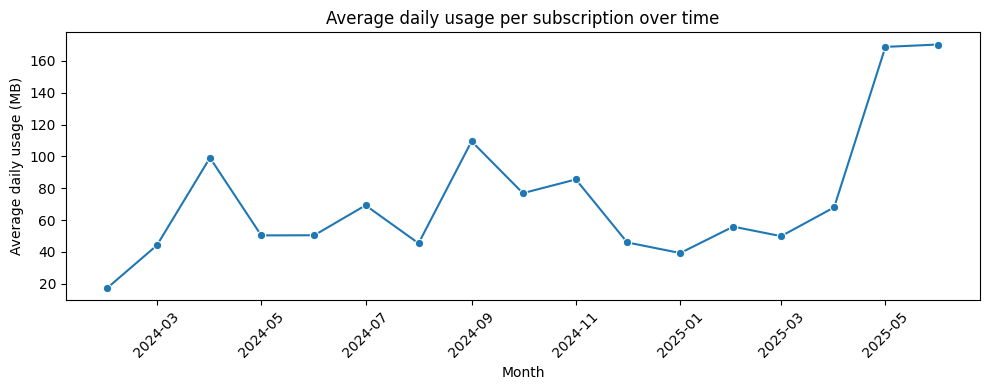

In [36]:
df_subscription_usage["last_reporting_date"] = pd.to_datetime(df_subscription_usage["last_reporting_date"])

# Extract month (as first day of month, good for plotting)
df_subscription_usage["month"] = df_subscription_usage["last_reporting_date"].dt.to_period("M").dt.to_timestamp()

# Average daily usage per month
monthly = (
    df_subscription_usage.groupby("month")["daily_usage"]
      .mean()
      .reset_index()
      .sort_values("month")
)

plt.figure(figsize=(10, 4))
sns.lineplot(data=monthly, x="month", y="daily_usage", marker="o")

plt.title("Average daily usage per subscription over time")
plt.xlabel("Month")
plt.ylabel("Average daily usage (MB)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# It shows a big spike in May and June - definitely something to look into. 
# It should be decomposed by plan type, organization, and heavy vs non-heavy users to understand what is driving the change

# Overview
It's difficult to define a single “typical” subscription because daily data usage is highly skewed. 
<br>On the full dataset, the **average daily usage is 126.6 MB**, while the **median is only 9.4 MB** - meaning a small number of very heavy users pull the average up strongly.
* If we remove the top and bottom 5% of subscriptions (to reduce the impact of outliers), the **average drops to 43.3 MB**, but the **median remains around 9.4 MB**.
* Given this skew, the **median of ~9–10 MB per day is a better representation of what a typical subscription consumes**. The large gap between mean and median suggests we should further segment the data (e.g. by plan type or other characteristics) to understand which segments drive the heavy usage and whether the high deviation is concentrated in specific groups or present across all categories.
* **Recent peak in average usage**: the monthly trend shows a significant increase in average daily usage in the last months. This requires a deep-dive: e.g. decomposed by plan type, organization, and heavy vs non-heavy users to understand what is driving the change (e.g. migration to Unlimited plans, onboarding of high-usage customers, or a surge in specific use cases).
<br>
<br>In addition, I've attached a list of subscriptions in the top 5% of daily usage (≥ 604 MB per day). These heavy users are likely driving a disproportionate share of total traffic and are good candidates for a more detailed review (e.g. by customer, plan type, and use case).


# 2. How does usage look like at different plan data allowances?

In [37]:
summary_by_plan = (
    df_subscription_usage
      .groupby("plan_type")["daily_usage"]
      .agg(["count", "mean", "median", "std", "min", "max"])
      .round(2)
)

print(summary_by_plan)

              count    mean  median     std   min       max
plan_type                                                  
1GB            5415   14.78    5.61   37.85  0.00   1805.80
5GB             890   74.34   29.46  158.66  0.00   2884.58
No Allowance     58  528.54   95.02  906.13  0.01   3617.07
Unlimited      1633  511.71  144.50  984.03  0.00  11748.00


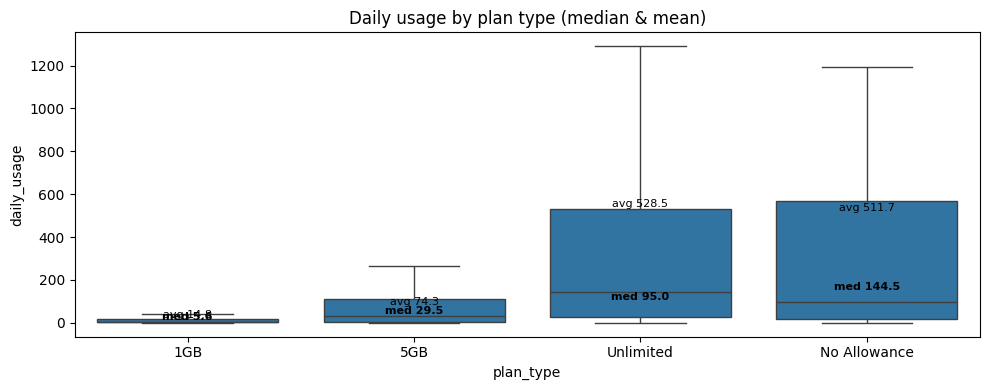

In [38]:
plt.figure(figsize=(10, 4))
ax = sns.boxplot(
    data=df_subscription_usage,
    x="plan_type",
    y="daily_usage",
    showfliers=False
)

stats = df_subscription_usage.groupby("plan_type")["daily_usage"].agg(["median", "mean"])

for i, (plan, row) in enumerate(stats.iterrows()):
    median = row["median"]
    mean   = row["mean"]

    # median label (just above the box)
    ax.text(i, median, f"med {median:.1f}",
            ha="center", va="bottom", fontsize=8, fontweight="bold")

    # mean label slightly higher so they don't overlap
    ax.text(i, mean, f"avg {mean:.1f}",
            ha="center", va="bottom", fontsize=8)

plt.title("Daily usage by plan type (median & mean)")
plt.tight_layout()
plt.show()

## Comments:
We see a similar picture here: data is very skewed on plan level as well. Let's remove the biggest outliers.

In [40]:
q_low  = df_subscription_usage["daily_usage"].quantile(0.05)
q_high = df_subscription_usage["daily_usage"].quantile(0.95)

df_trimmed_by_plan = df_subscription_usage[(df_subscription_usage["daily_usage"] >= q_low) & (df_subscription_usage["daily_usage"] <= q_high)]

summary_by_plan = (
    df_trimmed_by_plan
      .groupby("plan_type")["daily_usage"]
      .agg(["count", "mean", "median", "std", "min", "max"])
      .round(2)
)

print(summary_by_plan)

              count    mean  median     std   min     max
plan_type                                                
1GB            5114   15.15    6.13   27.72  0.17  491.77
5GB             834   69.39   34.86   83.36  0.17  577.89
No Allowance     41  116.98   46.90  151.40  0.37  597.91
Unlimited      1207  141.94   79.66  156.15  0.21  604.69


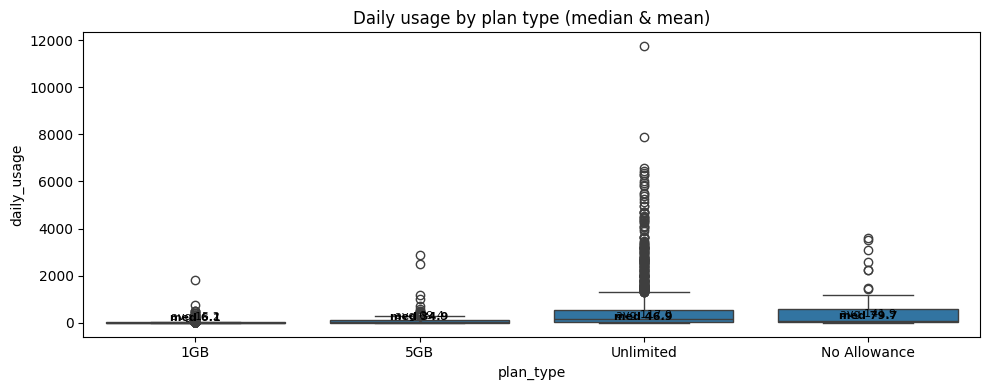

In [41]:
plt.figure(figsize=(10, 4))
ax = sns.boxplot(
    data=df_subscription_usage,
    x="plan_type",
    y="daily_usage"
)

stats = df_trimmed_by_plan.groupby("plan_type")["daily_usage"].agg(["median", "mean"])

for i, (plan, row) in enumerate(stats.iterrows()):
    median = row["median"]
    mean   = row["mean"]

    # median label (just above the box)
    ax.text(i, median, f"med {median:.1f}",
            ha="center", va="bottom", fontsize=8, fontweight="bold")

    # mean label slightly higher so they don't overlap
    ax.text(i, mean, f"avg {mean:.1f}",
            ha="center", va="bottom", fontsize=8)

plt.title("Daily usage by plan type (median & mean)")
plt.tight_layout()
plt.show()

# Overview
On a plan level we see a similar pattern of strong skewness as in the overall dataset. Using the full, untrimmed data, the mean daily usage is much higher than the median for every plan type, indicating that a relatively small number of heavy users drive a large share of the volume:
* 1GB: mean 14.8 MB/day, median 5.6 MB/day
* 5GB: mean 74.3 MB/day, median 29.5 MB/day
* No Allowance: mean 528.5 MB/day, median 95.0 MB/day
* Unlimited: mean 511.7 MB/day, median 144.5 MB/day

To reduce the impact of extreme outliers, I also looked at a trimmed view where the top and bottom 5% of subscriptions (by daily usage) were removed. In this trimmed dataset, the averages drop materially, but the medians remain more stable:
* 1GB: mean 15.2 MB/day, median 6.1 MB/day
* 5GB: mean 69.4 MB/day, median 34.9 MB/day
* No Allowance: mean 117.0 MB/day, median 46.9 MB/day
* Unlimited: mean 141.9 MB/day, median 79.7 MB/day

<br>Even after trimming, the distributions remain quite skewed, especially for Unlimited and No Allowance. 
<br>As expected, typical usage (median) is lowest on 1GB plans, higher on 5GB, and highest on Unlimited. 
<br>A notable outlier is the “No Allowance” plan, which still shows relatively high typical usage (median ~47 MB/day) despite nominally having no data allowance. It may point to a data or plan-coding issue, or to specific use cases where data is enabled via add-ons or pay-as-you-go mechanisms.
<br>
## Additional questions
<br>To understand these patterns better and to make this actionable, I would recommend a follow-up analysis along the following lines:
* **Recent peak in average usage**: The monthly trend shows a significant increase in average daily usage in the last months. This should be decomposed by plan type, organization, and heavy vs non-heavy users to understand what is driving the change (e.g. migration to Unlimited plans, onboarding of high-usage customers, or a surge in specific use cases).
* **Share of usage vs. share of subscriptions per plan**:
Quantify, for each plan type, what percentage of subscriptions it represents vs. what percentage of total data usage it generates (e.g. “Unlimited accounts for X% of subs but Y% of usage”).
* **Usage buckets by plan**:
Create daily-usage buckets (e.g. <1 MB/day, 1–10, 10–50, 50–200, >200) and calculate the percentage of subscriptions in each bucket per plan. This helps see whether each plan has a small group of “power users” or a generally high-usage base.
* **Deep dive on “No Allowance” plans**:
Check whether these subscriptions are short-lived spikes or long-lived with steady usage, and which organizations / projects / device types dominate this segment. This will help distinguish between data issues and genuine high-usage behaviour.
* **Subscription age effects within each plan**:
Compare daily usage between “younger” and “older” subscriptions (e.g. by quartiles of lifetime) for each plan type to see whether higher usage is driven by subscription age or is inherent to the plan design and its user base.


# 3. Compare the retention pattern for the most recently launched project versus the two older ones.

**1. Determine which project was the last**

In [42]:
%%sql
WITH prep AS (
    SELECT p.*, e.* EXCLUDE(project_id__hashed)
    FROM plan_events e
    LEFT JOIN projects p USING(project_id__hashed)
)

SELECT project_id__hashed, organization_name, MIN(plan_created_at), MAX(event_timestamp)
FROM prep
GROUP BY 1,2
ORDER BY 3, 4 DESC
/*Based on the first plan creation date, People Mobile seems to have the most recent project*/

,project_id__hashed,organization_name,min(plan_created_at),max(event_timestamp)
0,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,ACME Phone,2023-12-29 18:42:14,2025-10-04 10:09:40.396422
1,2aeca1a6c1ecf52b28b7f7646b6fb90563a417ee3e5dc3...,SmartDevices Inc.,2025-02-14 23:43:24,2025-04-25 09:01:00.697155
2,dace2786aee7632e61757b320a6fe5bff37a2e742fe558...,People Mobile,2025-03-03 18:42:39,2025-06-03 11:33:40.461513


**Analysing lifespan of each plan**

In [43]:
%%sql
CREATE OR REPLACE TABLE plan_lifespan_by_org AS
WITH prep AS (
    SELECT p.*, 
           e.* EXCLUDE(project_id__hashed),
           CASE
               WHEN is_unlimited_data THEN 'Unlimited'
               WHEN data_allowance_mb = 5000 THEN '5GB'
               WHEN data_allowance_mb = 1000 THEN '1GB'
               WHEN data_allowance_mb = 0 THEN 'No Allowance'
           END AS plan_type,
    
           /*since I don't know as of which date the analysis is conducted, let's assume that current date is 2025-10-04 (last event_timestamp in plan_events)*/
           CASE 
               WHEN event_type = 'plan.archived' THEN CAST(event_timestamp AS DATE)
               ELSE DATE('2025-10-05')
            END AS last_active_date,

            event_type = 'plan.archived' AS has_churned
    FROM plan_events e
    LEFT JOIN projects p USING(project_id__hashed)
    WHERE _is_current_state
)
SELECT organization_name, 
       project_type,
       device_type,
       plan_type,
       plan_created_at,
       event_timestamp,
       event_type,
       validity_unit,
       has_churned,
       last_active_date - CAST(plan_created_at AS DATE) AS lifespan_in_days
FROM prep
WHERE TRUE
ORDER BY organization_name, plan_created_at, event_timestamp

,Count
0,36


# Comments
<br> **Some of the plans are archived and re-created right away.** 
<br>   We'll assume that this is just a migration and will treat these cases as one plan (organization_name + project_type + device_type + plan_type).

In [44]:
%%sql
SELECT *
FROM plan_lifespan_by_org
WHERE organization_name = 'SmartDevices Inc.'
ORDER BY plan_created_at, event_timestamp

,organization_name,project_type,device_type,plan_type,plan_created_at,event_timestamp,event_type,validity_unit,has_churned,lifespan_in_days
0,SmartDevices Inc.,Connect,Wearables,5GB,2025-02-14 23:43:24,2025-02-14 23:43:25.882132,plan.updated,month,False,233
1,SmartDevices Inc.,Connect,Wearables,5GB,2025-02-25 19:23:23,2025-02-25 19:28:42.599043,plan.published,day,False,222
2,SmartDevices Inc.,Connect,Wearables,Unlimited,2025-02-25 19:26:53,2025-04-25 09:00:39.854671,plan.archived,day,True,59
3,SmartDevices Inc.,Connect,Wearables,Unlimited,2025-04-25 09:00:38,2025-04-25 09:01:00.697155,plan.published,day,False,163


In [46]:
%%sql
SELECT *
FROM plan_lifespan_by_org
WHERE organization_name = 'People Mobile'
ORDER BY plan_type, plan_created_at, event_timestamp
LIMIT 5

,organization_name,project_type,device_type,plan_type,plan_created_at,event_timestamp,event_type,validity_unit,has_churned,lifespan_in_days
0,People Mobile,API,Phones,5GB,2025-03-06 13:41:17,2025-03-06 13:49:53.389068,plan.archived,month,True,0
1,People Mobile,API,Phones,5GB,2025-03-06 13:49:53,2025-03-06 13:51:06.876123,plan.archived,month,True,0
2,People Mobile,API,Phones,5GB,2025-03-06 13:51:06,2025-03-25 18:08:27.329443,plan.archived,month,True,19
3,People Mobile,API,Phones,5GB,2025-03-25 18:08:27,2025-03-27 15:15:00.602786,plan.archived,day,True,2
4,People Mobile,API,Phones,5GB,2025-03-27 15:16:01,2025-04-02 01:36:41.219343,plan.archived,day,True,6


In [47]:
%%sql
SELECT *
FROM plan_lifespan_by_org
WHERE organization_name = 'ACME Phone'
ORDER BY plan_type, plan_created_at, event_timestamp


,organization_name,project_type,device_type,plan_type,plan_created_at,event_timestamp,event_type,validity_unit,has_churned,lifespan_in_days
0,ACME Phone,Connect,Phones,1GB,2023-12-29 18:42:14,2024-01-21 15:51:46.560897,plan.archived,day,True,23
1,ACME Phone,Connect,Phones,1GB,2024-01-21 15:51:46,2025-10-04 10:09:33.036819,plan.archived,month,True,622
2,ACME Phone,Connect,Phones,5GB,2023-12-29 18:42:44,2024-01-21 15:51:16.702594,plan.archived,day,True,23
3,ACME Phone,Connect,Phones,5GB,2024-01-21 15:51:15,2025-10-04 10:09:36.967075,plan.archived,month,True,622
4,ACME Phone,Connect,Phones,Unlimited,2023-12-29 18:43:12,2024-01-21 15:48:13.444971,plan.archived,day,True,23
5,ACME Phone,Connect,Phones,Unlimited,2024-01-21 15:48:11,2025-10-04 10:09:40.396422,plan.archived,month,True,622


**Building dataset that merges the migrations from plan to plan together**

In [50]:
%%sql
CREATE OR REPLACE TABLE plan_retention_merged AS
WITH ordered AS (
    SELECT
        organization_name,
        project_type,
        device_type,
        plan_type,
        plan_created_at,
        event_timestamp,
        event_type,
        validity_unit,
        has_churned,
        lifespan_in_days,
        /*previous event for the same logical plan_key*/
        LAG(event_timestamp) OVER w AS prev_event_ts,
        LAG(event_type) OVER w AS prev_event_type
    FROM plan_lifespan_by_org
    WINDOW w AS (PARTITION BY organization_name, project_type, device_type, plan_type ORDER BY plan_created_at, event_timestamp)
),

flagged AS (
    SELECT
        *,
        CASE
            /*adding a migration rule: if the change on the same plan happened within 24 hours, it's probably the same plan migration*/
            WHEN prev_event_type = 'plan.archived'
                 AND plan_created_at BETWEEN prev_event_ts - INTERVAL '24 hours'
                                         AND prev_event_ts + INTERVAL '24 hours'
            THEN 0
            ELSE 1   -- start a new logical plan chain
        END AS is_new_group
    FROM ordered
),

grouped AS (
    SELECT
        *,
        /*cumulative sum to assign a group id per logical plan "key"*/
        SUM(is_new_group) OVER w AS plan_group_id,

        /*index to capture the row order to later use the last row to reflect the last state of plan*/
        ROW_NUMBER() OVER w AS row_in_sequence
    FROM flagged
    WINDOW w AS (PARTITION BY organization_name, project_type, device_type, plan_type ORDER BY plan_created_at, event_timestamp)
),

merged AS (
    SELECT
        organization_name,
        project_type,
        device_type,
        plan_type,
        plan_group_id,
        MIN(plan_created_at) AS merged_plan_start,
        MAX(event_timestamp) AS merged_plan_end,
        arg_max(event_type, row_in_sequence) AS last_event_type
    FROM grouped
    GROUP BY 1,2,3,4,5
)

SELECT
    organization_name,
    project_type,
    device_type,
    plan_type,
    plan_group_id,
    merged_plan_start,
    merged_plan_end,
    EXTRACT(DAY FROM IF(last_event_type = 'plan.archived', merged_plan_end, DATE '2025-10-04') - merged_plan_start) + 1 AS merged_lifespan_days,
    last_event_type,
    (last_event_type = 'plan.archived') AS has_churned
FROM merged
ORDER BY 1, 6;

,Count
0,12


In [51]:
%%sql
SELECT *
FROM plan_retention_merged

,organization_name,project_type,device_type,plan_type,plan_group_id,merged_plan_start,merged_plan_end,merged_lifespan_days,last_event_type,has_churned
0,ACME Phone,Connect,Phones,1GB,1.0,2023-12-29 18:42:14,2025-10-04 10:09:33.036819,645,plan.archived,True
1,ACME Phone,Connect,Phones,5GB,1.0,2023-12-29 18:42:44,2025-10-04 10:09:36.967075,645,plan.archived,True
2,ACME Phone,Connect,Phones,Unlimited,1.0,2023-12-29 18:43:12,2025-10-04 10:09:40.396422,645,plan.archived,True
3,People Mobile,API,Phones,No Allowance,1.0,2025-03-03 18:42:39,2025-04-15 21:07:14.228616,44,plan.archived,True
4,People Mobile,API,Phones,5GB,1.0,2025-03-06 13:41:17,2025-04-09 20:12:44.848071,212,plan.published,False
5,People Mobile,API,Phones,Unlimited,1.0,2025-03-06 13:41:39,2025-04-21 16:05:02.202080,47,plan.archived,True
6,People Mobile,API,Phones,No Allowance,2.0,2025-04-10 08:11:20,2025-04-10 20:30:37.994851,177,plan.updated,False
7,People Mobile,API,Phones,Unlimited,2.0,2025-04-15 18:30:51,2025-06-03 11:33:40.461513,172,plan.updated,False
8,People Mobile,API,Phones,Unlimited,3.0,2025-05-23 18:56:56,2025-05-23 18:56:57.821855,134,plan.updated,False
9,SmartDevices Inc.,Connect,Wearables,5GB,1.0,2025-02-14 23:43:24,2025-02-14 23:43:25.882132,232,plan.updated,False


# Overview
**Note on methodology**: 
<br>For this retention view, I treated cases where the same plan within the same project was closed and then re-created within 24 hours as a migration rather than true churn, and merged them into a single logical plan. A more complete analysis could validate this assumption by checking whether the commercial terms (e.g. pricing) actually changed between versions, but I’ve skipped that step here to keep the work lightweight, as this is handled as an ad-hoc request.

## Old projects:

**1. ACME Phone - Connect - Phones**
* 3 plans (1GB, 5GB, Unlimited)
* All three lasted ~645 days (≈ 21 months) and are now archived (has_churned = TRUE).
* Pattern: very long-lived, stable plans that stayed unchanged for a long time before being retired.

**Summary:**
ACME's plans show long retention: all launched in December 2023 and lasted ~21 months before being archived. 
<br>This suggests a mature, relatively stable project with infrequent plan changes. 
<br>The fact that they were all archived in one day strongly suggests a shared, deliberate reason rather than organic churn of individual plans, e.g.: 
* a portfolio-wide migration
* a product clean-up
* sunset of the underlying project



**2. SmartDevices Inc. - Connect - Wearables**
* 3 plans (two 5GB variants + one Unlimited).
* All three are still active (has_churned = FALSE), with effective lifespans of roughly 220–230 days up to the reference date (Feb 2025 → Oct 2025).
* There is some iteration (test 5GB plan vs Basic 5GB), but once the "real" plans are in place they stay live.

**Summary:** SmartDevices’ project has no churned plans so far. 
<br> All current plans have been live for around 7-8 months, indicating good early retention and relatively low experimentation compared to People Mobile.
<br>
## Most recent project:
**3. People Mobile - API - Phones**
<br> Retention pattern is quite different from the older Connect projects. In the early phase, we see several plans (e.g. No Allowance and Unlimited) with short lifetimes of only ~1–1.5 months before they are archived. That points to a period of heavy iteration / testing, rather than stable long-term plans.
<br> Later generations of plans - the current 5GB, No Allowance and Unlimited variants - have now been active for roughly 4–7 months and are still live (last events are plan.updated / plan.published, not archived). This suggests that after an initial experimentation phase, the portfolio has stabilised and is starting to behave more like the older projects in terms of plan lifetime.
<br> Some of this difference could be structural: People Mobile runs an API-based project, which supports more dynamic integration and faster change cycles than the Connect projects. So the shorter early lifetimes and higher “churn” of individual plans could be driven more by product and integration changes than by classic customer churn.